# Epidemic spreading dynamics 
## Lorenzo Venieri

Monte Carlo simulation of an epidemic spreading dynamics in complex networks, using the SIS model. Each node represents an individual which can be in two possible state: Susceptible (S), i.e. healthy but can get infected: Infected (I), i.e. has the disease and can spread it to the neighbors.

In [198]:
import networkx as nx
import time
import numpy as np
import random as rd
import matplotlib.pyplot as plt
from itertools import combinations
import powerlaw
from scipy import stats
import copy

%matplotlib inline

# Monte Carlo simulation

• u: spontaneous recovery probability.  
• b: infection probability of a susceptible (S) individual when it is contacted by an
infected (I) one.

In [10]:
Nrep = 50
p_0 = 0.2 #initial fraction of infected nodes 
Tmax = 1000
Ttrans = 900

def SIS_simulation(G,u,b, plot_time=False):
    #computes one rep of the Monte Carlo simulation
    sus = set(G.nodes)
    N = len(sus)
    inf = set()
    n_p_0 = round(p_0 * len(sus))
    inf_0 = set(rd.sample(sus, n_p_0))
    inf = inf | inf_0
    sus = sus - inf_0
    P = 0
    p_t=[0,]
    for t in range(0,Tmax):
        new_sus = set() # nomore_inf
        new_inf = set() # nomore_sus
        
        for i in inf:
            if rd.random() < u:
                new_sus.add(i) # = nomore_inf.add(i)
                
        #if we want to allow one-step reinfections we have to update here sus:
        #sus = sus | new_sus
        
        for s in sus:
            for n in G.neighbors(s):
                if n in inf and rd.random() < b:
                    new_inf.add(s) # = nomore_sus.add(s)
                    break
        sus = (sus | new_sus) - new_inf
        inf = (inf | new_inf) - new_sus
        
        #one-step reinfections:
        #sus = sus - new_inf
        #inf = (inf - new_sus) | new_inf
        
        #check if it works:
        if len(sus)+len(inf) != N:
            print('Error: #S + #I must be = N')
            return
        
        if plot_time == True:
            inf_len = len(inf)
            p_t.append(inf_len/N)
        if t>=Ttrans:
            P+=len(inf)
            
    p = P/(N*(Tmax-Ttrans))
    
    if plot_time == True:
        plt.figure(figsize=(10,6))
        plt.title(f'N = {N}, u = {u}, b = {b}')
        plt.plot(p_t)
        
    return p


In [14]:
#Monte Carlo simulation

def MC(G, Nrep, u, b):
    sum_p = 0
    for i in range(0,Nrep):
        sum_p += SIS_simulation(G, u, b)
    return sum_p/Nrep

#different b parameters analized:
b_arr = np.linspace(0, 1.0, num=51)

def plots(G, name, u_list=[0.1, 0.5, 0.9]):
    fig, ax = plt.subplots(figsize=(10,6))
    plt.title(name)
    ax.set_ylim([0, 1])
    plt.grid()
    dict_={}
    for u in u_list:
        p_list_ = []
        for b in b_arr:
            p = MC(G, Nrep, u, b)
            p_list_.append(p)
        ax.plot(b_arr, p_list_, '-o', markersize=3, label = 'u = {}'.format(u))
        dict_[u]=p_list_
    plt.xlabel('b')
    plt.ylabel('<p>')
    plt.legend()
    plt.savefig('plot_'+name)
    
    return dict_

# Microscopic Markov Chain Approach (MMCA)  

Theoretical prediction for p(b) provided by the MMCA model.

In [77]:
def MMCA_prediction(G,u,b,p_0):
    nodes = G.nodes
    N = len(nodes)
    p = [p_0]*N
    p_time = [p_0,]
    cycle_found=False
    for t in range(500):
        q = [1]*N
        for i in nodes:
            for j in G.neighbors(i):
                #r_ij = a_ij = 1 for neighbour nodes: CP, unweighted graph
                #an infected node contacts all its neighbors during a time step
                q[i] *= 1 - b * p[j]
                #q_r[i] *= (1 - b * p_r[j]) #with one-step reinfections
        for i in nodes:
            p[i] = (1-p[i])*(1-q[i])+(1-u)*p[i] #no one-step reinfections
            #p_r[i] = (1-q_r[i])+(1-u)*p_r[i]*q_r[i] #with one-step reinfections
        p_mean = np.mean(p)
        if p_mean in p_time:
            cycle_found = True
            break
        p_time.append(p_mean)
    
    #mean between the oscillating values:
    if cycle_found:
        for i in range(len(p_time)):
            if p_time[i]==p_mean:
                osc_p_mean = p_time[i:]
    else: 
    #when u approaches 1 are needed more time-steps to find a cycle
    #For time efficiency we take the last 100 values
        osc_p_mean = p_time[-100:]
    mean_osc = np.mean(osc_p_mean)
    return mean_osc

def MMCA_combinations(G, u_list=[0.1, 0.5, 0.9]):
    dict_ = {}
    for u in u_list:
        p_list_ = []
        for b in b_arr:
            p = MMCA_prediction(G,u,b,p_0)
            p_list_.append(p)
        dict_[u] = p_list_
    return dict_

In [97]:
def plot_comparison(simulation, prediction, u_list, name):
    fig, ax = plt.subplots(figsize=(10,6))
    ax.set_ylim([0, 1])
    plt.xlabel('b')
    plt.ylabel('<p>')
    plt.title(f'Comparison MC/MMCA: {name}')
    for u in u_list:
        plt.plot(b_arr,simulation[u], label='simulated, u = {}'.format(u))
        plt.plot(b_arr,prediction[u],'o', label='predicted, u = {}'.format(u))
    plt.legend()
    plt.grid()
    plt.savefig('comparison_'+name)

In [75]:
#function to plot the evolution through time of the MMCA prediction

def MMCA_time_plot(G,u,b,p_0):
    nodes = G.nodes
    N = len(nodes)
    p = [p_0]*N
    p_r = [p_0]*N
    p_time=[p_0,]
    p_r_time=[p_0,]
    for t in range(100):
        q = [1]*N
        q_r = [1]*N
        for i in nodes:
            for j in G.neighbors(i):
                #r_ij = a_ij = 1 for neighbour nodes: CP, unweighted graph
                #an infected node contacts all its neighbors during a time step
                q[i] *= (1 - b * p[j])
                q_r[i] *= (1 - b * p_r[j])
        for i in nodes:
            p[i] = (1-p[i])*(1-q[i])+(1-u)*p[i] #no one-step reinfections
            p_r[i] = (1-q_r[i])+(1-u)*p_r[i]*q_r[i] #with one-step reinfections
        p_mean = np.mean(p)
        p_r_mean = np.mean(p_r)
        p_time.append(p_mean)
        p_r_time.append(p_r_mean)
    plt.figure()
    plt.title(f'u = {u}, b = {b}, p_0 = {p_0}')
    plt.plot(p_time, label='no reinf')
    plt.plot(p_r_time, label='reinf')
    plt.xlabel('t')
    plt.ylabel('<b>')
    plt.legend()
    return #p_time
               

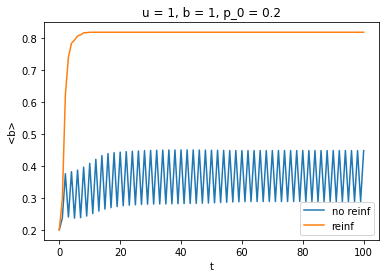

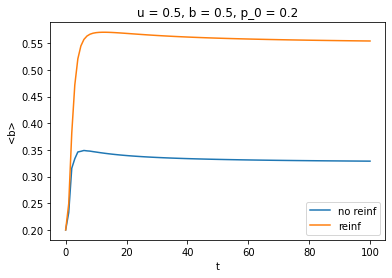

In [79]:
#two examples
MMCA_time_plot(CM_SF_500_27,1,1,0.2)
MMCA_time_plot(CM_SF_500_27,0.5,0.5,0.2)

## Functions to create the networks analized  
(Taken from the models project (continuous assessment activity #2)

In [1]:
#Model G(N,K) by Erdős & Rényi
#K is the number of edges
#the average node degree is <k> = 2*K/N

def ER_Gnk(N,K):
    G=nx.Graph()
    G.add_nodes_from([i for i in range(N)])
    n_edges=0
    while n_edges<K:
        edge=rd.choice(list(combinations(G,2)))
        if (edge[0],edge[1]) not in G.edges():
            G.add_edge(edge[0],edge[1])
            n_edges+=1
    return G

In [64]:
#Configuration Model with given node degrees distribution

def CM(node_degrees): 
    if np.sum(node_degrees)%2==1:
        print('the sum of the node degrees must be even')
        return 
    G=nx.Graph()
    G.add_nodes_from([i for i in range(len(node_degrees))])
    #construct the list of stubs
    v=[]
    for n,d in enumerate(node_degrees):
        for _ in range(d):
            v.append(n)
    #random permutation of v 
    rd.shuffle(v) #(in-place)
    bad_edges=[]
    for i in range(0,len(v),2):
        if v[i]==v[i+1]: #avoid self-loops
            bad_edges+=[v[i],v[i+1]]
        elif (v[i],v[i+1]) in G.edges(): #avoid multi-edges
            bad_edges+=[v[i],v[i+1]]
        else:
            G.add_edge(v[i],v[i+1])
    #we reshuffle the bad_edges list to try new couples, we set a counter to stop if the 
    #remaining nodes are ineligible to form new valid edges
    counter=0
    stop=10
    #print(bad_edges)
    bad_edges_shuffled=bad_edges
    while len(bad_edges)!=0 and counter<stop:
        rd.shuffle(bad_edges_shuffled)
        bad_edges=[]
        for i in range(0,len(bad_edges_shuffled),2):
            if bad_edges_shuffled[i]==bad_edges_shuffled[i+1]:
                bad_edges+=[bad_edges_shuffled[i],bad_edges_shuffled[i+1]]
            elif (bad_edges_shuffled[i],bad_edges_shuffled[i+1]) in G.edges():
                bad_edges+=[bad_edges_shuffled[i],bad_edges_shuffled[i+1]]
            else:
                G.add_edge(bad_edges_shuffled[i],bad_edges_shuffled[i+1])
            counter+=1
            #print(counter)
    #print('remaining nodes: ' , bad_edges)
    return G


#function to create a scale free distribution

def SF_even(N, l):
    #generates node_degrees with power-law distribution and even sum of degrees
    th=powerlaw.Power_Law(xmin=1.0, parameters = [l])
    th_gen=th.generate_random(N);
    node_degrees=list(np.floor(th_gen).astype(int))
    
    #could be done in many ways...
    #node_degrees=np.floor((1./scipy.stats.powerlaw.rvs(a=l,size=N))).astype(int)
    #powerlaw: f(x,a)=ax^(a-1), a>0, 1>=x>=0
    
    #we need the sum of the degrees to be even to construct the edges
    if np.sum(node_degrees)%2==1:
        node_degrees[0]+=1
    node_degrees=np.array(node_degrees)
    
    return node_degrees


# ER Networks

### ER, N = 500, < k > = 6

In [13]:
N=500
avg_degree=6
K=N*(avg_degree)/2
ER_500_6 = ER_Gnk(N,K)
nx.write_pajek(ER_500_6, "ER_500_6.net")

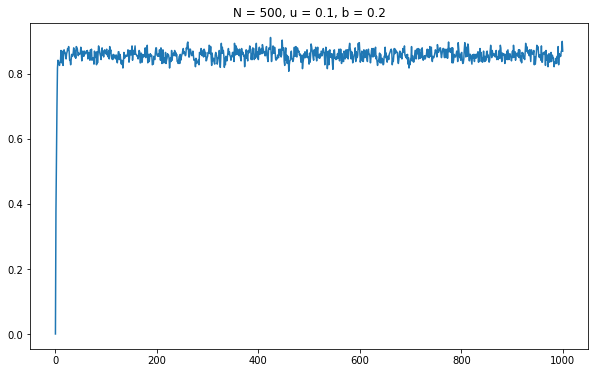

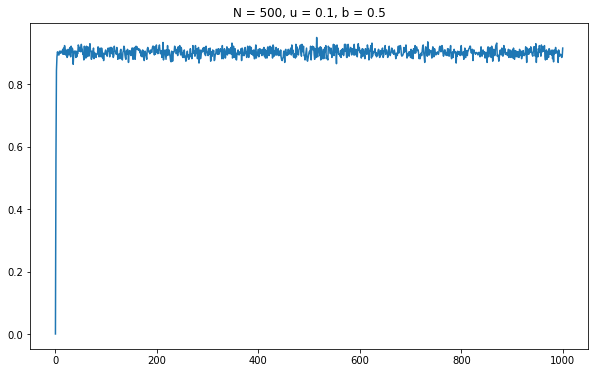

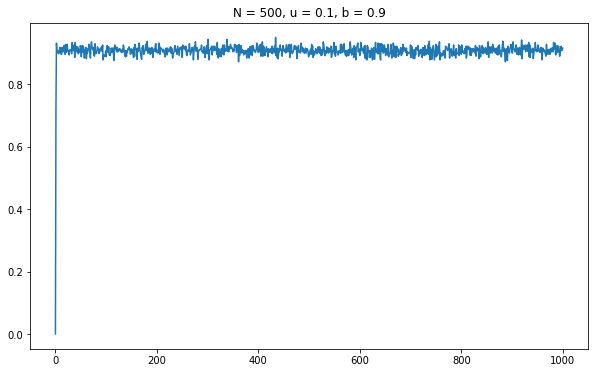

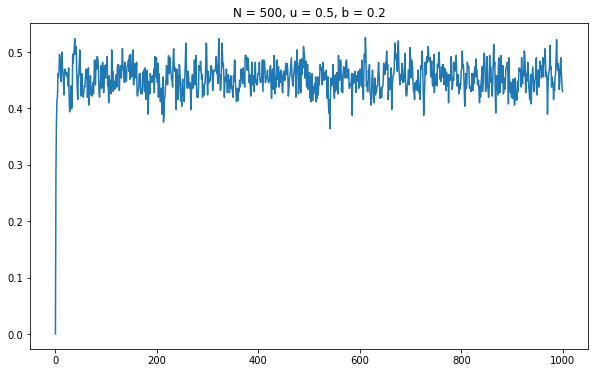

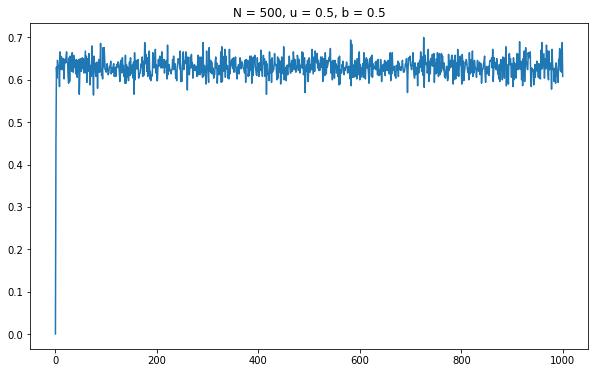

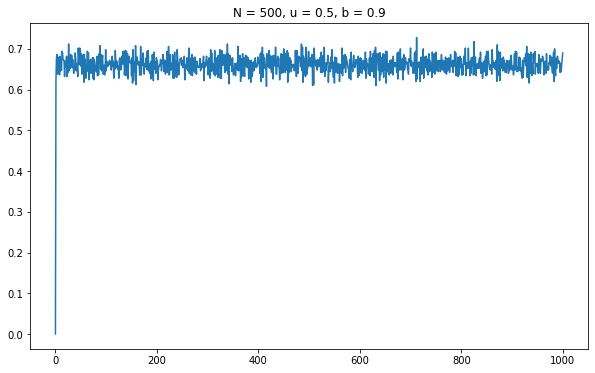

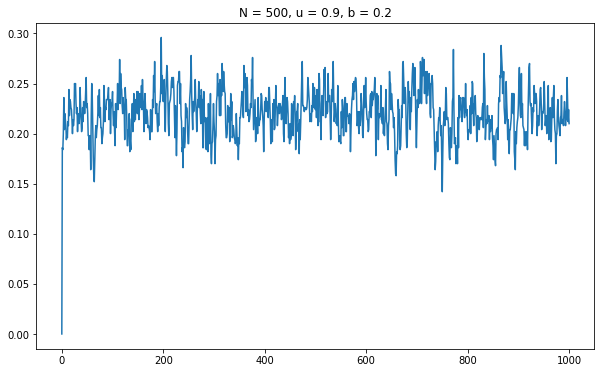

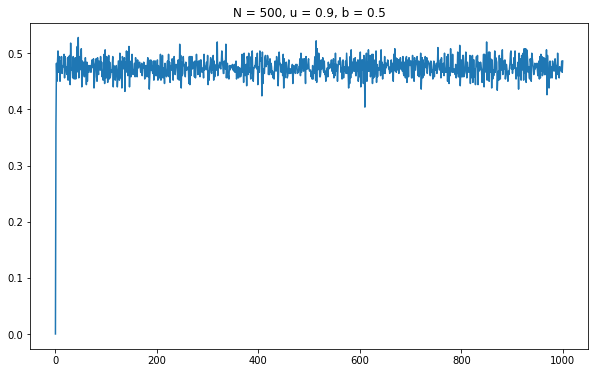

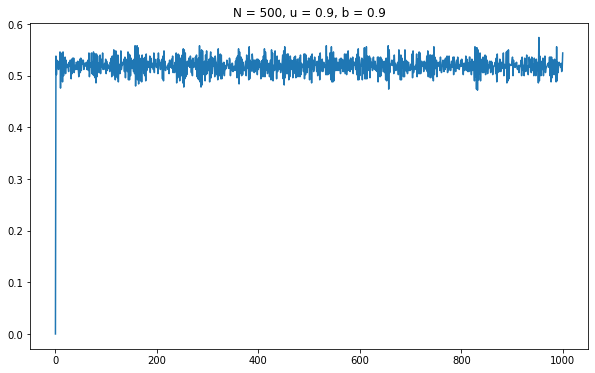

In [184]:
Ttrans=900
Tmax=1000
u_list = [0.1, 0.5, 0.9]
for u in u_list:
    for b in [0.2,0.5,0.9]:
        SI_simulation(ER_500_6, u, b, plot_time=True)

For this network the transitory state ends before the 100th step. We can adjust Ttrans and Tmax accordingly to reduce the time needed for the MC simulation.

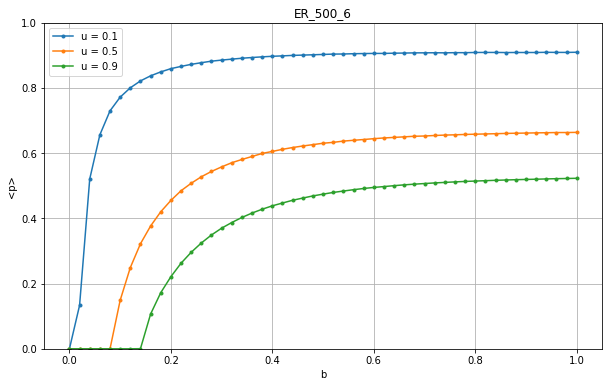

In [185]:
Ttrans = 200
Tmax = 300
Nrep = 100
dict_ER_500_6 = plots(ER_500_6,'ER_500_6')

In [17]:
MMCA_ER_500_6 = MMCA_combinations(ER_500_6)

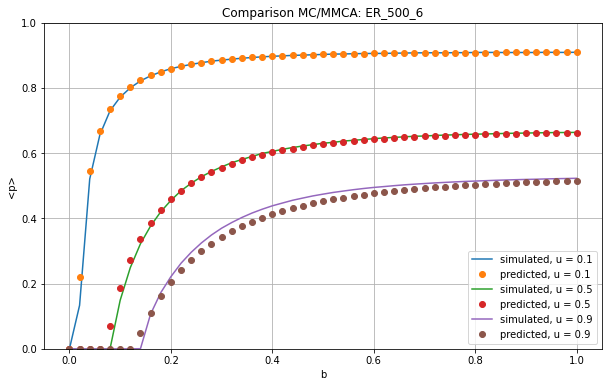

In [187]:
plot_comparison(dict_ER_500_6, MMCA_ER_500_6, u_list, 'ER_500_6')

### ER, N=1000, < k > = 12

In [46]:
N=1000
avg_degree=12
K=N*(avg_degree)/2
ER_1000_12 = ER_Gnk(N,K)
nx.write_pajek(ER_1000_12, "ER_1000_12.net")

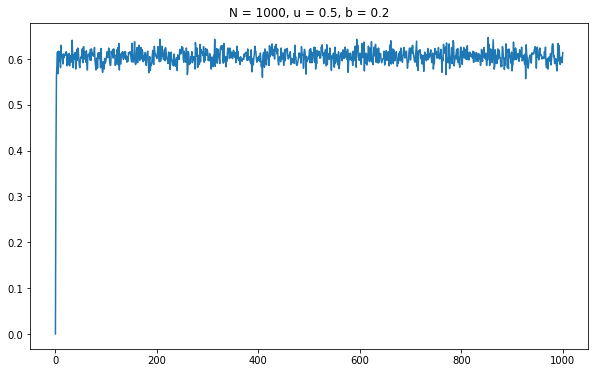

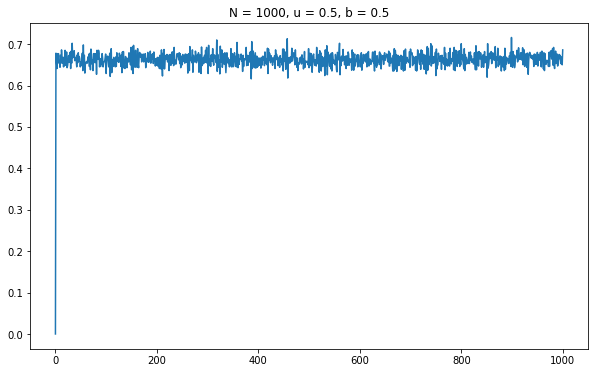

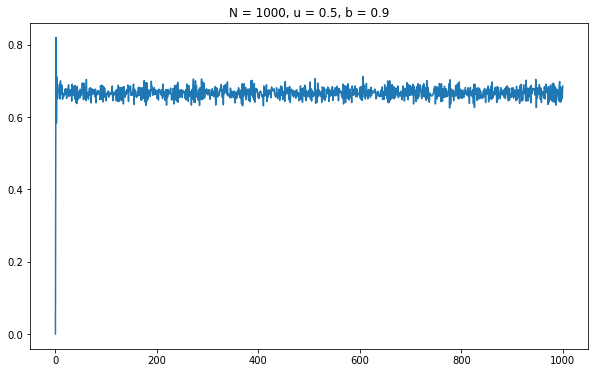

In [186]:
u=0.5
Tmax=1000
for b in [0.2,0.5,0.9]:
    SIS_simulation(ER_1000_12, u, b, plot_time=True)

We can use the same Ttrans and Tmax as before.

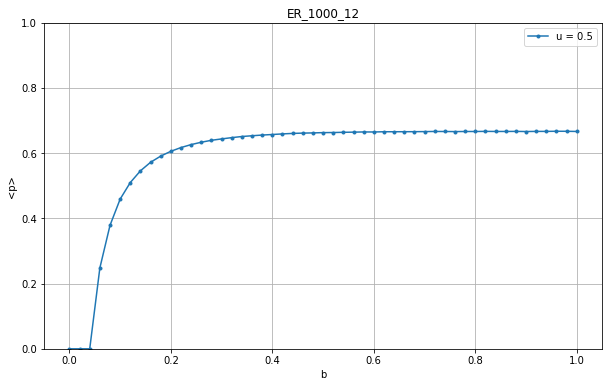

In [188]:
Ttrans = 100
Tmax = 300
Nrep = 100
u_list=[0.5]
dict_ER_1000_12 = plots(ER_1000_12,'ER_1000_12', u_list)

In [56]:
MMCA_ER_1000_12 = MMCA_combinations(ER_1000_12, u_list)

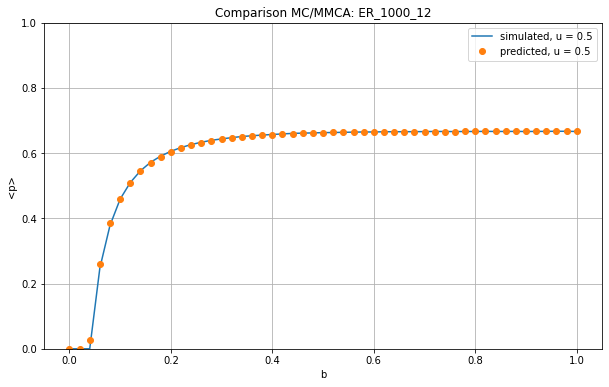

In [189]:
plot_comparison(dict_ER_1000_12, MMCA_ER_1000_12, u_list, 'ER_1000_12')

# Scale-Free networks

### SF N=500 gamma=2.7

In [65]:
N=500
gamma=2.7
node_degrees=SF_even(N, gamma)
CM_SF_500_27=CM(node_degrees)
nx.write_pajek(CM_SF_500_27, "CM_SF_500_27")

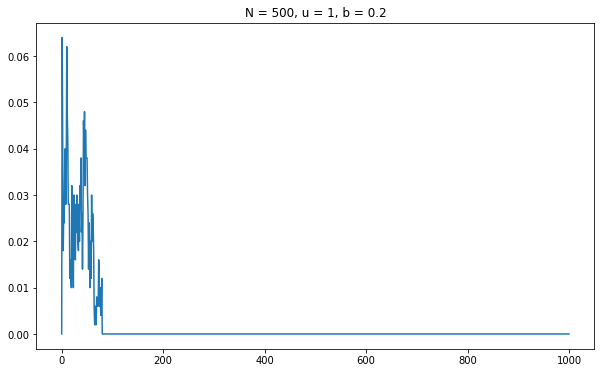

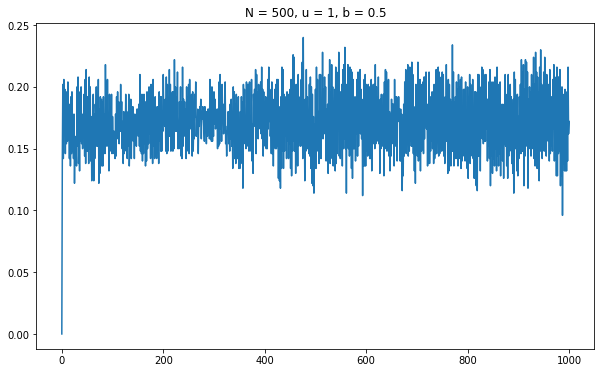

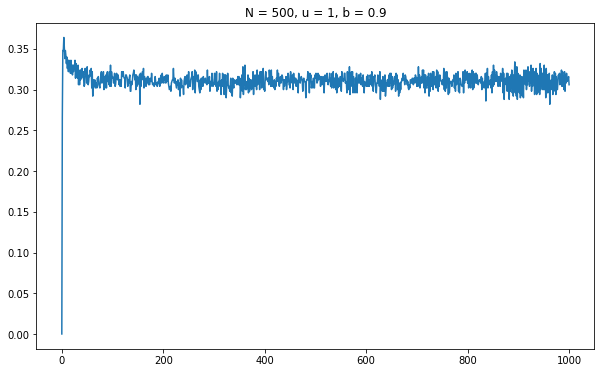

In [84]:
u=1
Ttrans = 900
Tmax = 1000
for b in [0.2,0.5,0.9]:
    SIS_simulation(CM_SF_500_27, u, b, plot_time=True)

Also here the stationary state is reached before the 200th step. We adjust Ttrans and Tmax.

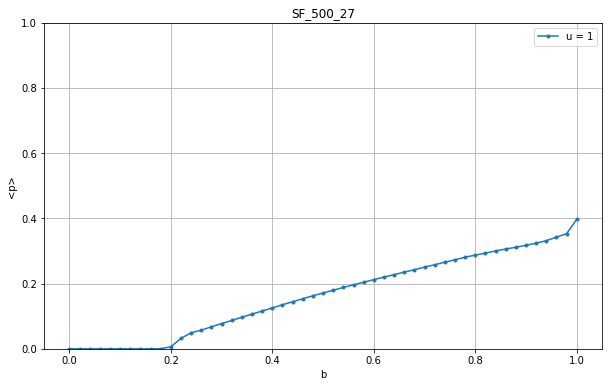

In [73]:
Ttrans = 200
Tmax = 400
Nrep = 100
u_list=[1]
dict_SF_500_27 = plots(CM_SF_500_27,'SF_500_27', u_list)

In [69]:
MMCA_SF_500_27 = MMCA_combinations(CM_SF_500_27, u_list)

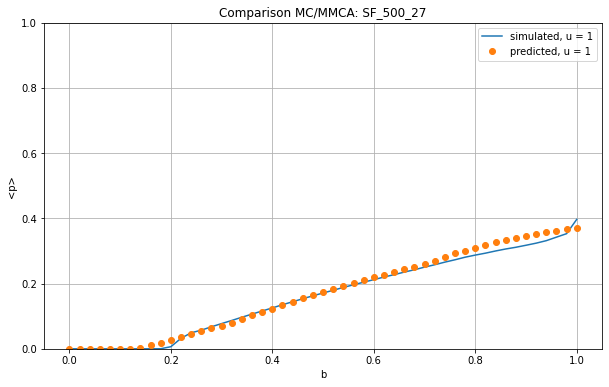

In [104]:
plot_comparison(dict_SF_500_27, MMCA_SF_500_27, u_list, 'SF_500_27')

### SF N=500 gamma=4.0

In [80]:
N=500
gamma=4.0
node_degrees=SF_even(N, gamma)
CM_SF_500_40=CM(node_degrees)
nx.write_pajek(CM_SF_500_40, "CM_SF_500_40")

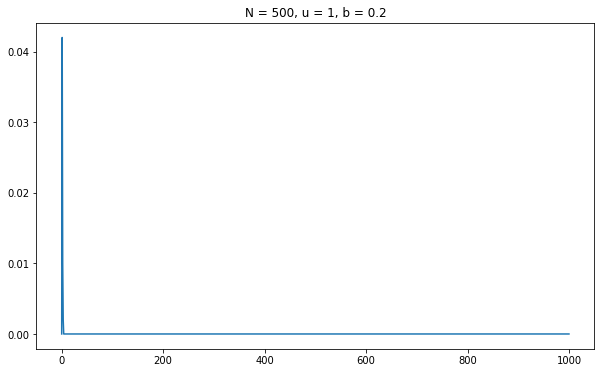

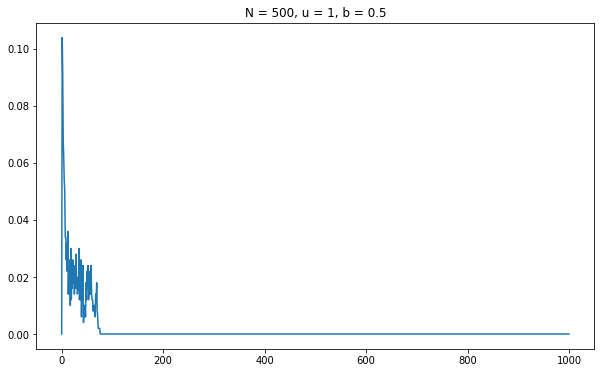

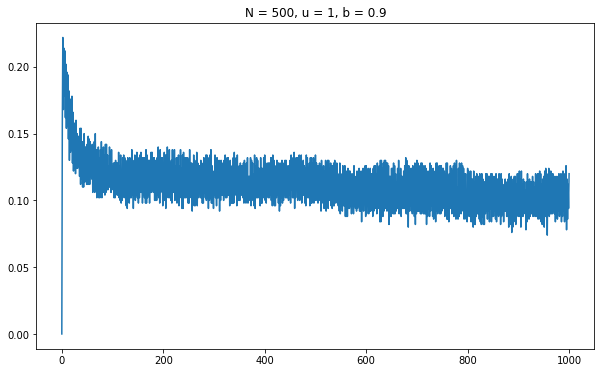

In [85]:
u=1
Ttrans = 900
Tmax = 1000
for b in [0.2,0.5,0.9]:
    SIS_simulation(CM_SF_500_40, u, b, plot_time=True)

For this network the stationary state starts later. We keep Ttrans=900 and Tmax=1000.

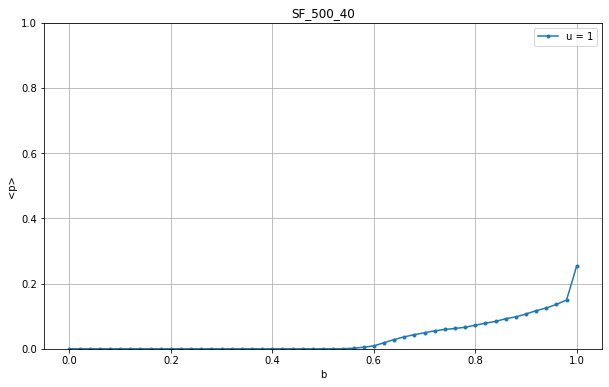

In [89]:
Ttrans = 900
Tmax = 1000
Nrep = 100
u_list=[1]
dict_SF_500_40 = plots(CM_SF_500_40,'SF_500_40', u_list)

In [87]:
MMCA_SF_500_40 = MMCA_combinations(CM_SF_500_40, u_list)

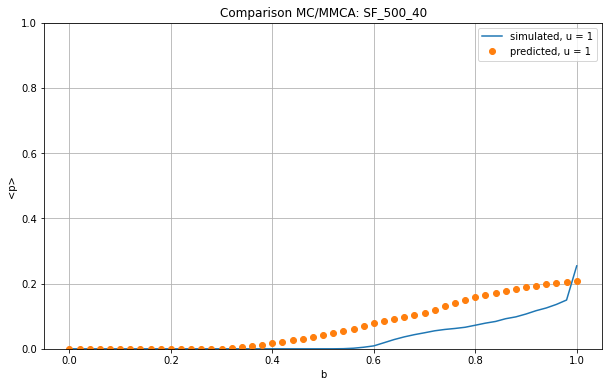

In [105]:
plot_comparison(dict_SF_500_40, MMCA_SF_500_40, u_list, 'SF_500_40')

# Real networks

## Airports network

In [194]:
path='Networks/airports_UW.net'
airports=nx.read_pajek(path)
airports=nx.convert_node_labels_to_integers(airports)

In [129]:
len(airports.nodes())

3618

In [130]:
len(airports.edges())

14142

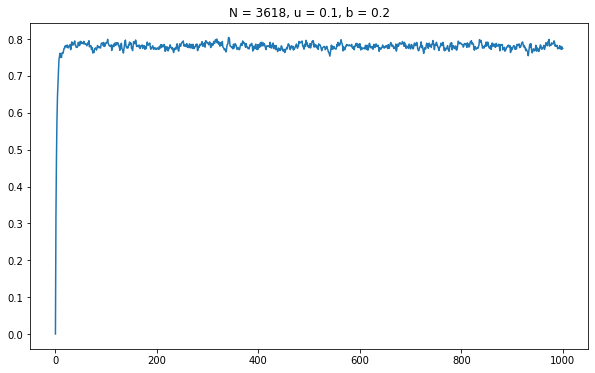

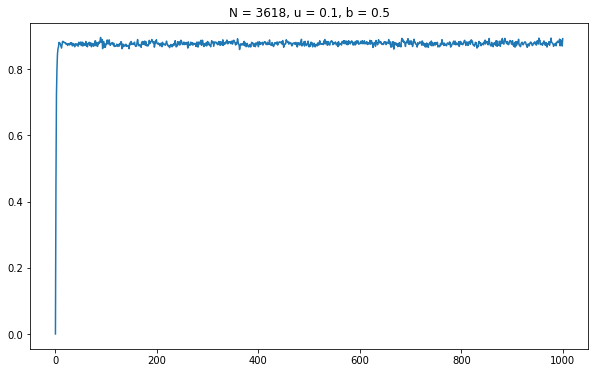

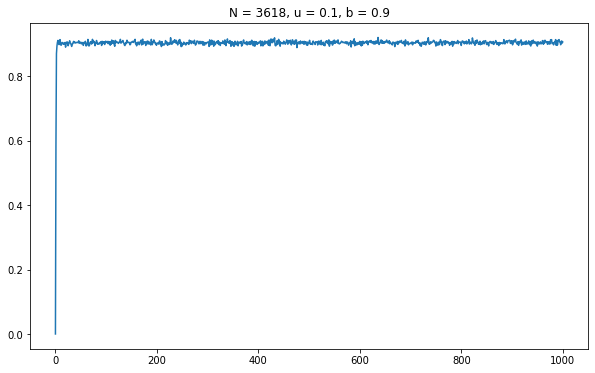

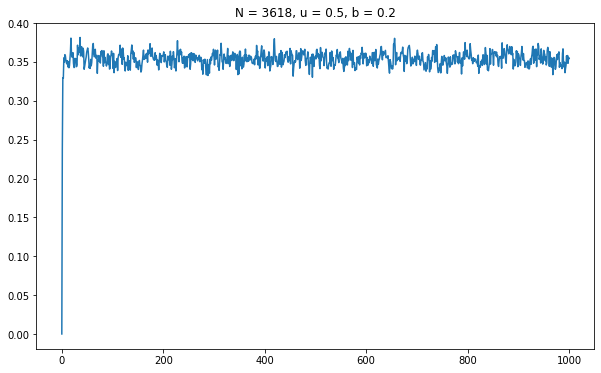

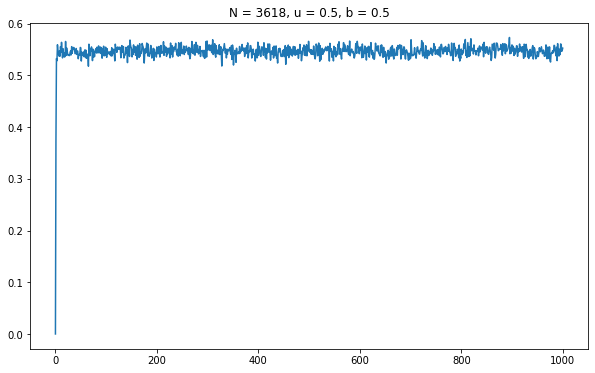

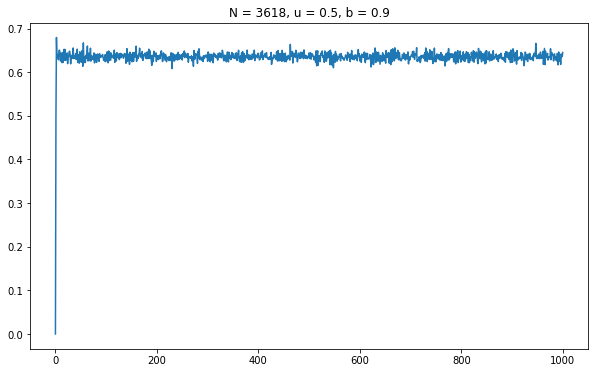

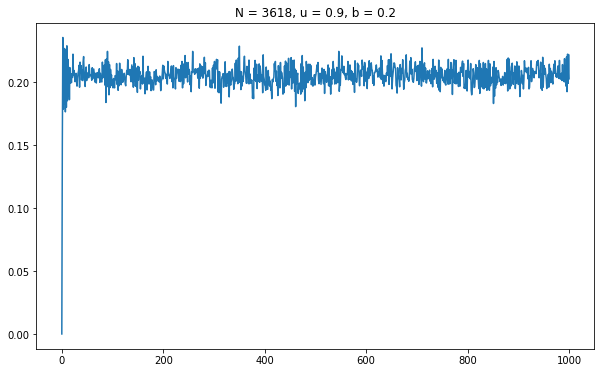

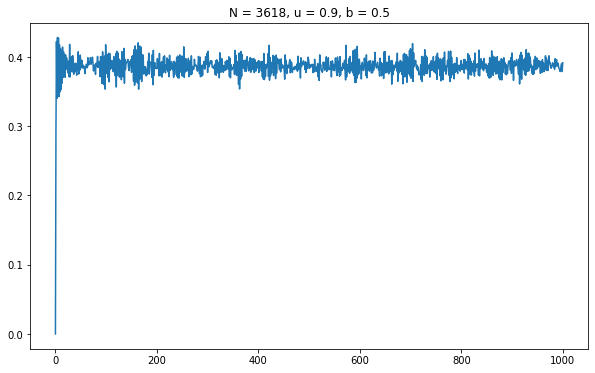

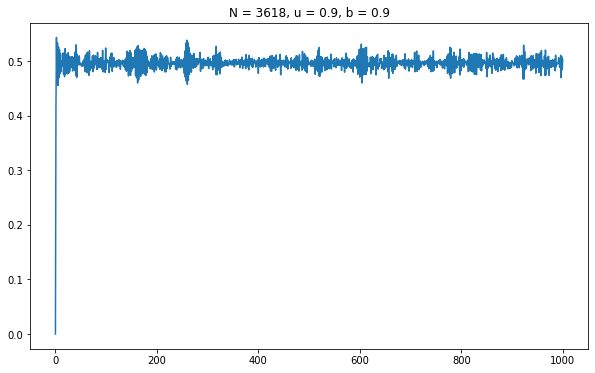

In [92]:
u_list=[0.1,0.5,0.9]
Ttrans = 900
Tmax = 1000

for u in u_list:
    for b in [0.2,0.5,0.9]:
        SIS_simulation(airports, u, b, plot_time=True)

The stationary state is reached before t=100, we adjust Ttrans and Tmax.

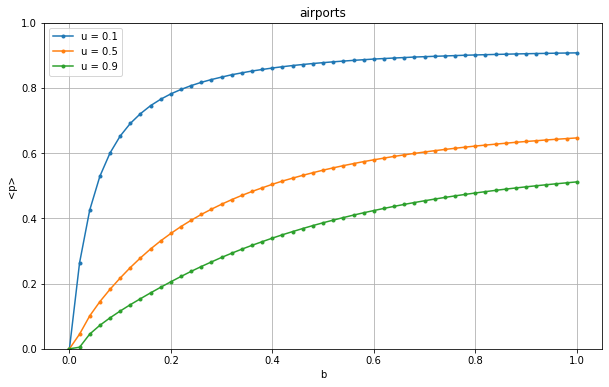

In [95]:
Ttrans = 100
Tmax = 300
Nrep = 50

dict_airports = plots(airports,'airports', u_list)

In [94]:
MMCA_airports = MMCA_combinations(airports, u_list)

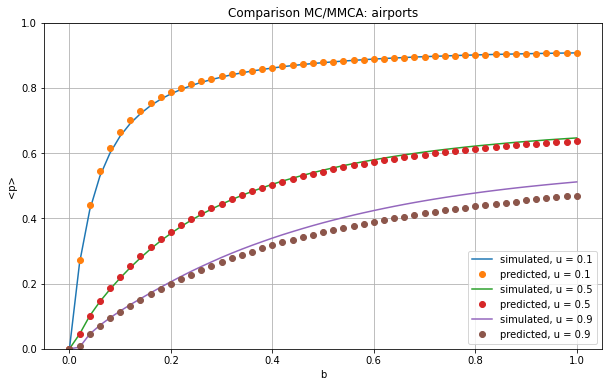

In [107]:
plot_comparison(dict_airports, MMCA_airports, u_list, 'airports')

## Erdos collaboration network

http://vlado.fmf.uni-lj.si/pub/networks/data/

In [109]:
path_erdos = 'Networks/ErdosCollaboration.net'
erdos=nx.read_pajek(path_erdos)
erdos=nx.convert_node_labels_to_integers(erdos)

In [113]:
len(erdos.nodes)

6927

In [181]:
len(erdos.edges)

574

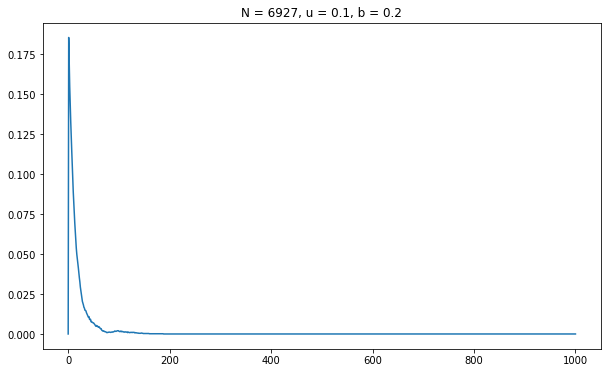

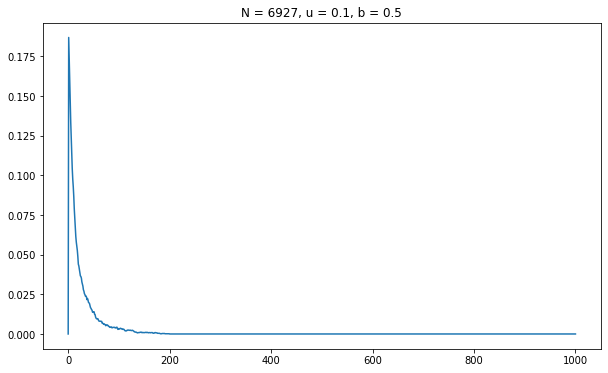

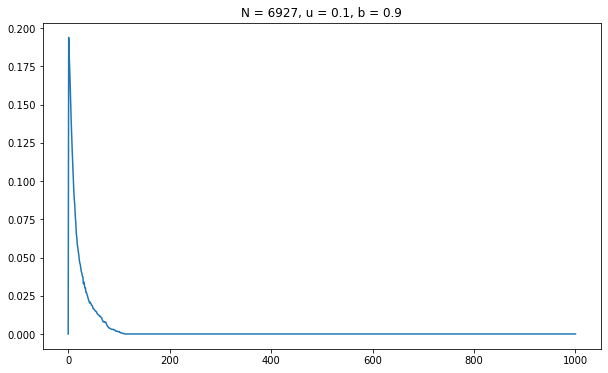

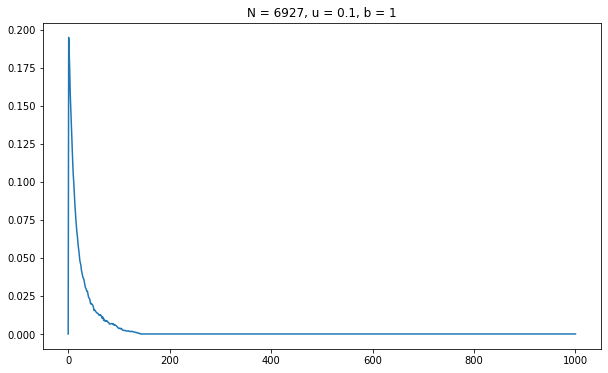

In [141]:
u_list=[0.1]
Ttrans = 900
Tmax = 1000

for u in u_list:
    for b in [0.2,0.5,0.9, 1]:
        SIS_simulation(erdos, u, b, plot_time=True)

The network is very sparse and the epidemic dies out.

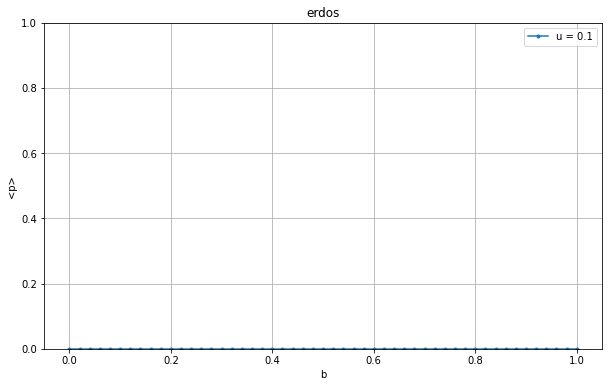

In [143]:
Nrep = 50

dict_erdos = plots(erdos,'erdos', u_list)

In [144]:
MMCA_erdos = MMCA_combinations(erdos, u_list)

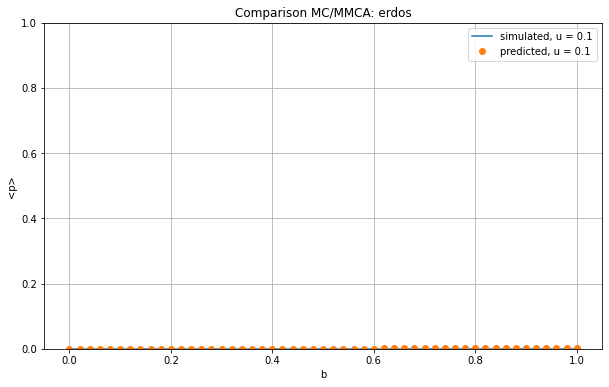

In [145]:
plot_comparison(dict_erdos, MMCA_erdos, u_list, 'erdos')

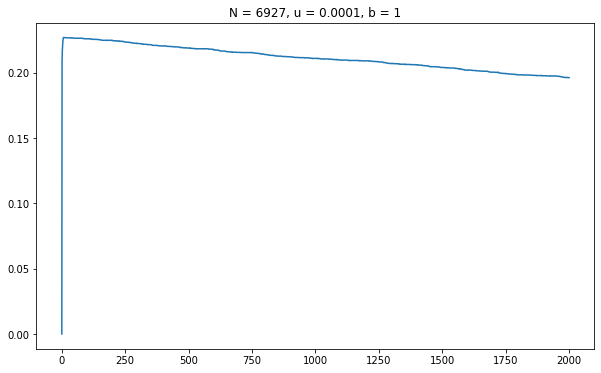

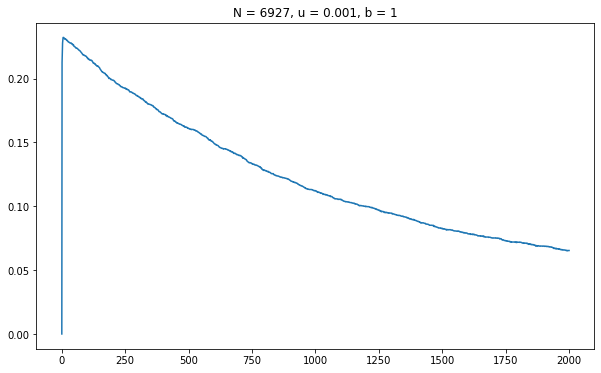

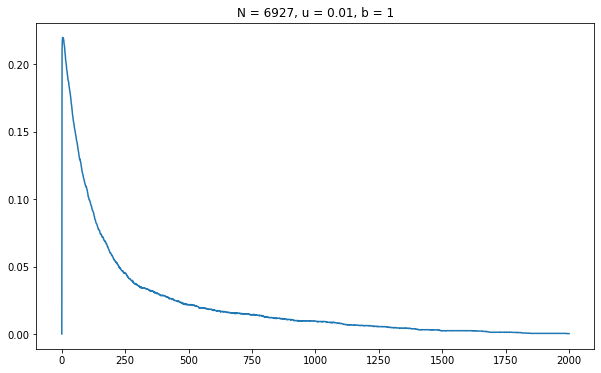

In [150]:
#fixed b=1, let's try to find a u s.t. the epidemic doesn't die out immediately
Tmax=2000
for u in [0.0001, 0.001, 0.01]:
    SIS_simulation(erdos, u, b=1, plot_time=True)

0.2271589432654829

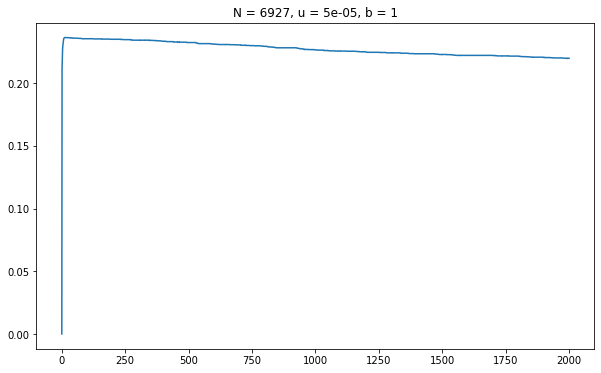

In [193]:
Tmax=2000
SIS_simulation(erdos, 0.00005, b=1, plot_time=True)

For u = 0.01 the fraction of infected nodes becomes close to 0 at the 200th time step.  
For u = 0.001 and u = 0.0001 the fraction of infected nodes keeps decreasing during the timespan considered

# Facebook

This dataset contains 'circles' (or 'friends lists') from Facebook. https://snap.stanford.edu/data/ego-Facebook.html

In [133]:
path_fb = 'Networks/facebook_combined.txt'
facebook = nx.read_edgelist(path_fb)
facebook=nx.convert_node_labels_to_integers(facebook)

In [196]:
nx.write_pajek(facebook, "Networks/facebook.net")

In [125]:
len(facebook.nodes())

4039

In [126]:
len(facebook.edges())

88234

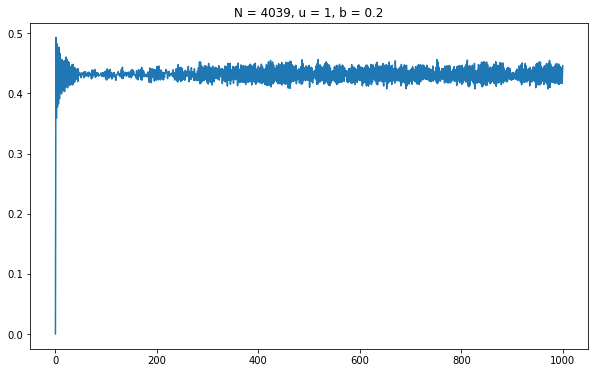

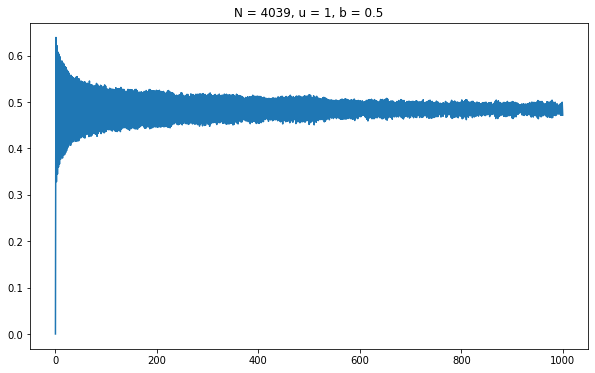

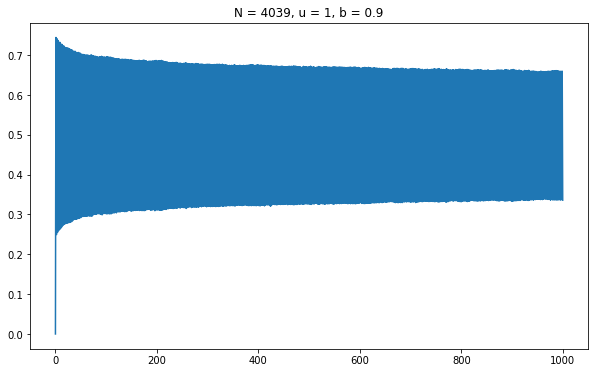

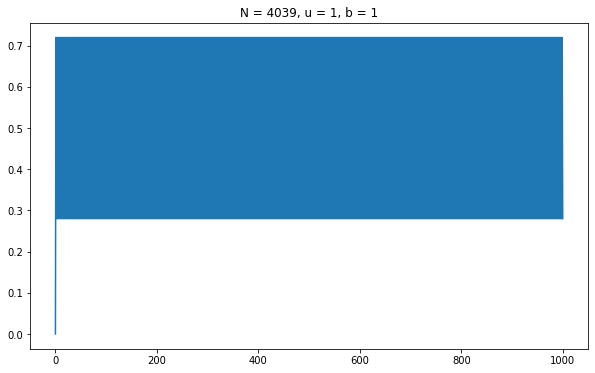

In [128]:
u_list=[1]
Ttrans = 900
Tmax = 1000

for u in u_list:
    for b in [0.2,0.5,0.9, 1]:
        SIS_simulation(facebook, u, b, plot_time=True)

The network reaches the stationary state pretty fast and then it oscillates quite a lot, we can keep Ttrans = 900 and Tmax = 1000

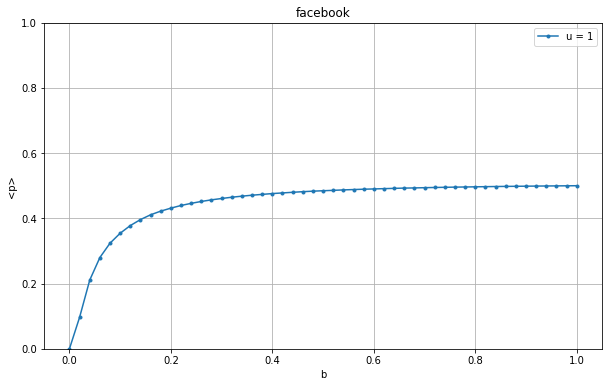

In [131]:
Nrep = 50
dict_fb = plots(facebook,'facebook', u_list)

In [134]:
MMCA_fb = MMCA_combinations(facebook, u_list)

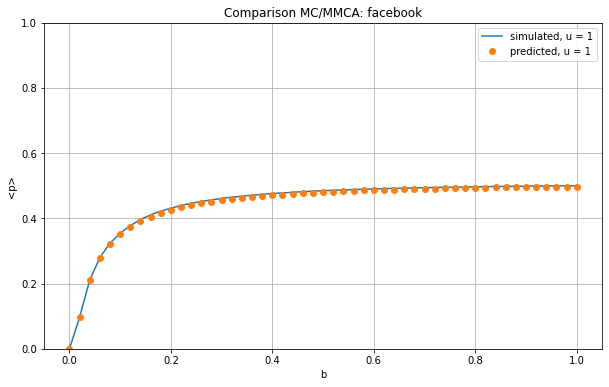

In [135]:
plot_comparison(dict_fb, MMCA_fb, u_list, 'facebook')
